In [7]:
%run setup.py

/Users/yaguang/micromamba/envs/numax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Select sample
- RGB from APOKASC (Pinsonneault+2018 x Kallinger+2019)
- Subgiants (Li+2022) and main-sequence stars (Lund+2017)

APOGEE metallicity, SYD Dnu and numax

In [97]:
# sdss dr16
apogee = pd.read_csv(rootpath+'../database/xcatalog/yu+2018_x_sdss_dr16_allstar.csv')
ka = pd.read_csv(rootpath+'../database/rgRGpeakbagging/summary.dat', delimiter=';')
apogee = apogee.merge(ka, how='inner', on='KIC')

idx = (apogee['Phase']==1) & (apogee['Delnu']>2.5) & (apogee['M_H']>-10.) & \
        (apogee['dnu02']/apogee['Delnu'] > 0.1) & (apogee['dnu02']/apogee['Delnu'] <0.17)
apogee = apogee[idx] #.merge(gaia, how='inner', on='KIC')

# get columns and rename 
oldcols = ['TEFF', 100, 'M_H', 0.06, 'Delnu', 'e_Delnu', 'numax', 'e_numax']
newcols = ['Teff_spec', 'e_Teff_spec', '[M/H]', 'e_[M/H]', 'Dnu', 'e_Dnu', 'numax', 'e_numax']
for icol in range(len(oldcols)):
    if type(oldcols[icol])==str:
        apogee[newcols[icol]] = apogee[oldcols[icol]] 
    else:
        apogee[newcols[icol]] = oldcols[icol]
rg = apogee[['KIC']+newcols]

In [99]:
# get gaia columns and 2mass magnitudes
gaia = pd.read_csv(rootpath+'../database/xcatalog/yu+2018_x_gaia_edr3_x_2mass_x_wise.csv')
cols = ['KIC', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag', 
        'astrometric_params_solved', 'nu_eff_used_in_astrometry', 'pseudocolour', 'ecl_lat', 
        'j_m', 'j_msigcom', 'h_m' , 'h_msigcom', 'k_m', 'k_msigcom']
rg = rg.merge(gaia[cols], how='inner', on='KIC')

In [100]:
# get distances
dist = pd.read_csv(rootpath+'../database/xcatalog/yu+2018_x_bailor_jones+21.csv')[['KIC', 'rpgeo']]
rg = rg.merge(dist, how='inner', on='KIC')

In [101]:
# get ebv extinction
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarQuery

# Note that below, we could use version='bayestar2017' to get the newer
# version of the map. Note, however, that the reddening units are not
# identical in the two versions of the map. See Green et al. (2018) for
# an explanation of the units.
bayestar = BayestarQuery()

ra, dec, dist = star['ra'], star['dec'], star['rpgeo']
coords = SkyCoord(ra=ra*units.deg, dec=dec*units.deg,
                  distance=dist*units.pc, frame='icrs')

ebv = bayestar(coords, mode='median')
star['ebv'] = ebv

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 47.415 s
  pix_info:   1.165 s
   samples:  33.603 s
      best:   4.755 s
       nan:   0.030 s
      sort:   7.705 s
       idx:   0.157 s


In [102]:
# get corrected g band magnitudes
# Anthony Brown et al.
# https://github.com/agabrown/gaiaedr3-6p-gband-correction
def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, numpy.ndarray
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, numpy.ndarray
        The G-band magnitude as listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 2-paramater or 6-parameter astrometric solution fainter than G=13, 
    for which a (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr, gflux_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<13) | (astrometric_params_solved == 31)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>=13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    
    return gmag_corrected

rg['phot_g_mean_mag_corr'] = correct_gband(np.array(rg['phot_bp_mean_mag']-rg['phot_rp_mean_mag']), 
              np.array(rg['astrometric_params_solved']),
              np.array(rg['phot_g_mean_mag']))

In [107]:
# get logg from numax
rg['logg'] = np.log10((rg['numax']/3090)*(rg['Teff_spec']/5777.)**0.5 * 27400)

In [108]:
# get IRFM photometric Teff
# Lucas Casagrande et al. 2021
# https://github.com/casaluca/colte
from colte import colte
colte(np.array(rg['KIC']),
      np.array(rg['logg']), #np.array(rg['logg'])+0.2, #np.array(rg['logg'])-0.2,
      np.array(rg['[M/H]']),
      np.array(rg['phot_g_mean_mag_corr']),
      np.array(rg['phot_bp_mean_mag']),
      np.array(rg['phot_rp_mean_mag']),
      np.array(rg['j_m']),
      np.array(rg['h_m']),
      np.array(rg['k_m']),
      np.array(rg['ebv']),
      DR3=True, MC=True)

In [111]:
irfm = pd.read_csv('colte.csv')
irfm['KIC'] = irfm['#star_name']
irfm['Teff'] = irfm['wTeff']
irfm['e_Teff'] = 100
irfm = irfm[['KIC', 'Teff', 'e_Teff']]
rg = rg.merge(irfm, how='inner', on='KIC')

In [ ]:
# get luminosities
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import astropy.units as units
from zero_point import zpt
zpt.load_tables()

from isoclassify.direct import classify as classify_direct
from isoclassify.extinction import query_dustmodel_coords

# BC model
# DATADIR = '/Volumes/Data/Onedrive/github/isoclassify/data/'
DATADIR = os.getenv('HOME')+'/github/isoclassify/data/'
fn = os.path.join(DATADIR,'bcgrid.h5')
bcmodel = h5py.File(fn,'r', driver='core', backing_store=False)


idx = np.isfinite(rg['phot_g_mean_mag']) & (rg['j_m']>-1000)
for istar, star in rg.loc[idx,:].iterrows():
    
    ra, dec = star['ra'], star['dec']
    if star['Teff']>0:
        Teff, eTeff = star['Teff'], star['e_Teff']
    else:
        continue

    if star['[M/H]']>-1000:
        FeH, eFeH = star['[M/H]'], star['e_[M/H]']
    else:
        continue
    
    if star['logg']>-10:
        logg, elogg = star['logg'], 0.1 #star['e_logg']
    else:
        continue
    
    plx, eplx = star['parallax']*1e-3, star['parallax_error']*1e-3
    jmag, ejmag = star['j_m'], star['j_msigcom']
    kmag, ekmag = star['k_m'], star['k_msigcom']
    
    phot_g_mean_mag = star['phot_g_mean_mag']
    nu_eff_used_in_astrometry = star['nu_eff_used_in_astrometry']
    pseudocolour = star['pseudocolour']
    ecl_lat = star['ecl_lat']
    astrometric_params_solved = star['astrometric_params_solved']
    
    zero = zpt.get_zpt(phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved)
    zero = zero*1e-3

    # # 3 - K mag
    # Reddening maps
    x = classify_direct.obsdata()
    x.addcoords(ra, dec)

    dustmap = 'green19'
    dustmodel, ext = query_dustmodel_coords(x.ra, x.dec, dustmap)

    # SPECTROSCOPY 
    x.addspec([Teff, logg, FeH],[eTeff, elogg, eFeH])

    # PARALLAX
    x.addplx(plx-zero, eplx*1.3)

    # MAGNITUDE
    # To use for the distance modulus
    x.addmag([kmag],[ekmag])

    paras = classify_direct.stparas(x, bcmodel=bcmodel, dustmodel=dustmodel, band='kmag', ext=ext)
    
    rg.loc[istar, 'luminosity'] = paras.lum
    rg.loc[istar, 'e_luminosity'] = (paras.lumem+paras.lumep)/2.

/suphys/yali4742/anaconda3/lib/python3.7/site-packages/isoclassify/extinction.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

using max distance: 1405.8
using min distance: 1204.3
   
teff(K): 4633.0 +/- 100.0
dis(pc): 1298.2986749867498 + 27.257499974999973 - 26.229517295172855
av(mag): 0.2751796834607367 + 0.0 - 0.0
rad(rsun): 8.116551523416742 + 0.42327370065072145 - 0.39900269394889776
lum(lsun): 27.25318790968788 + 1.4828196795043311 - 1.3980423506586312
mabs( kmag ): -0.966364390538282 + 0.05717580892513463 - 0.057522797532402525
fbol(cgs): 5.171604954690102e-10 + 1.7356474531016968e-11 - 1.668742610118334e-11
mass(msun): 0.0 + 0.0 - 0.0
density(rhosun): 0.0 + 0.0 

In [128]:
# idx = rg['e_luminosity']/rg['luminosity'] < 0.1
# rg.loc[idx,:].to_csv('sample/rg.csv',index=False)

In [131]:
rg = pd.read_csv('sample/rg.csv')

In [231]:
# get modes from Kallinger+19
rgmodes = pd.DataFrame(columns = ['KIC', 'l', 'fc', 'e_fc'])

for istar, star in rg.loc[:,:].iterrows():
    filepath = '../../database/KeplerRGpeakbagging/ModeFiles/{:0.0f}.modes.dat'.format(star['KIC'])

    if not os.path.exists(filepath): continue 
    modes = pd.read_fwf(filepath, skiprows=7)
    
    l = [(modes['l']==l) & (modes['ev']>0.91) for l in range(0,3)]
    Dnu = star['Dnu']
    
    # modes.loc[l[0],'include']=True
    for im, m in modes.loc[l[0],:].iterrows():
        idx = (modes['freq']>(m['freq']-1.1*Dnu)) & (modes['freq']<(m['freq']-0.1*Dnu)) & (m['freq']>star['numax']) & l[0]
        if np.sum(idx)==1:
            modes.loc[im,'include']=True
            
        idx = (modes['freq']>(m['freq']+0.1*Dnu)) & (modes['freq']<(m['freq']+1.1*Dnu)) & (m['freq']<star['numax']) & l[0]
        if np.sum(idx)==1:
            modes.loc[im,'include']=True
        
        idx = (modes['freq']>(m['freq']-0.3*Dnu)) & (modes['freq']<(m['freq']-0.05*Dnu)) & l[2]
        if np.sum(idx)==1:
            modes.loc[idx,'include']=True
            
    modes['fc'] = modes['freq']
    modes['e_fc'] = modes['freq_err']
    new_modes = modes.loc[modes['include']==True, ['l', 'fc', 'e_fc']]
    new_modes['KIC'] = star['KIC']
    rgmodes = pd.concat([rgmodes, new_modes], ignore_index=True)

In [232]:
rgmodes['KIC'] = rgmodes['KIC'].astype(int)

In [233]:
rgmodes.to_csv('sample/modes_rg.csv',index=False)

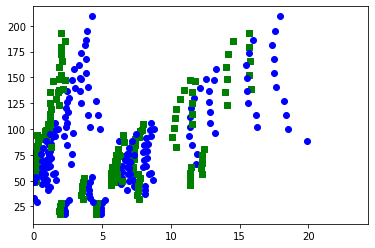

In [246]:
for istar, star in rg.loc[:10,:].iterrows():
# for istar, star in rg.loc[rg['KIC']==5016549,:].iterrows():
    modes = rgmodes.loc[rgmodes['KIC']==star['KIC'],:]
    ls = [modes['l']==l for l in range(0,4)]
    Dnu = star['Dnu']
    plt.scatter(modes.loc[ls[0],'fc'] % Dnu, modes.loc[ls[0],'fc'], c='b', marker='o')
    plt.scatter(modes.loc[ls[2],'fc'] % Dnu, modes.loc[ls[2],'fc'], c='g', marker='s')
    plt.scatter(modes.loc[ls[0],'fc'] % Dnu + Dnu, modes.loc[ls[0],'fc'], c='b', marker='o')
    plt.scatter(modes.loc[ls[2],'fc'] % Dnu + Dnu, modes.loc[ls[2],'fc'], c='g', marker='s')
    plt.xlim(0,2*Dnu)

# Select the binary sample to constrain amlt

In [269]:
old = pd.read_excel('../surface/sample/samples.xlsx')

idx = (old['names']=='binary') & (old['stage']=='rgb') 
old = old[idx].reset_index(drop=True)
# apogee = apogee[idx] #.merge(gaia, how='inner', on='KIC')

gaiacols = ['ra_error', 'dec_error', 'parallax',
       'parallax_error', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag', 
        'astrometric_params_solved', 'nu_eff_used_in_astrometry', 'pseudocolour', 'ecl_lat', 
        'j_m', 'j_msigcom', 'h_m' , 'h_msigcom', 'k_m', 'k_msigcom']

oldbinarycols = ['mass_dyn', 'e_mass_dyn', 'radius_dyn', 'e_radius_dyn']
newbinarycols = ['star_mass', 'e_star_mass', 'radius', 'e_radius']

# # get columns and rename 
oldcols = ['Teff_apo', 100, '[M/H]_apo', 0.06, 'Dnu', 'e_Dnu', 'numax', 'e_numax', 
           'ra_1', 'dec_1', 'Teff_phot', 100, 'lum_K', 'e_lum_K'] + oldbinarycols + gaiacols
newcols = ['Teff_spec', 'e_Teff_spec', '[M/H]', 'e_[M/H]', 'Dnu', 'e_Dnu', 'numax', 'e_numax', 
           'ra', 'dec', 'Teff', 100, 'luminosity', 'e_luminosity'] + newbinarycols + gaiacols
for icol in range(len(oldcols)):
    if type(oldcols[icol])==str:
        old[newcols[icol]] = old[oldcols[icol]] 
    else:
        old[newcols[icol]] = oldcols[icol]
binary = old[['KIC']+newcols]

In [276]:
# binary.to_csv('sample/samples_eb.csv',index=False)

In [293]:
binary = pd.read_csv('sample/samples_eb.csv')

In [296]:
# get Dnu
from grid import get_model_Dnu

modes_eb = pd.read_csv('sample/modes_eb.csv')
for istar, star in binary.iterrows():
    idx = (modes_eb['KIC'] == star['KIC']) & (modes_eb['l']==0)
    tm = modes_eb[idx].reset_index(drop=True)
    Dnu, e_Dnu = get_obs_Dnu(tm['fc'].to_numpy(), tm['e_fc'].to_numpy(), np.median(np.diff(tm['fc'])))
    
    binary.loc[istar, 'Dnu'], binary.loc[istar, 'e_Dnu'] = Dnu, e_Dnu

In [298]:
binary.to_csv('sample/samples_eb.csv', index=False)

# Get luminosity from color, Teff, plx, etc.

In [276]:
Teff_sun = 5777.0
numax_sun = 3090.0
Dnu_sun = 135.1
g_sun = 10.0**4.43796037457

# Get seismic scaling parameters with Teff

In [11]:
Teff_sun = 5777.0
numax_sun = 3090.0
Dnu_sun = 135.1
g_sun = 10.0**4.43796037457

from fdnu import asfgrid

idx = (rg['ifmodelling']==1) &(rg['KIC']==1) #& np.isfinite(rg['Teff']) & np.isfinite(rg['m_h'])

feh = np.array(rg.loc[idx,'m_h'])
Teff = np.array(rg.loc[idx,'Teff'])
e_Teff = np.array(rg.loc[idx,'e_Teff'])
Dnu = np.array(rg.loc[idx,'Dnu'])
e_Dnu = np.array(rg.loc[idx,'e_Dnu'])
numax = np.array(rg.loc[idx,'numax'])
e_numax = np.array(rg.loc[idx,'e_numax'])
evstate=np.zeros((rg.loc[idx,"Dnu"].shape[0],))+1
s=asfgrid.Seism(datadir=rootpath+"fdnu/")
mass_fdnu, radius_fdnu = s.get_mass_radius(evstate,feh,Teff,Dnu,numax,fill_value='linear',isfeh=True)
lum_fdnu =  (radius_fdnu)**2. *(Teff/Teff_sun)**4.
rg.loc[idx,'scaling_logg_fdnu'] = np.log10(mass_fdnu/radius_fdnu**2. * g_sun)
rg.loc[idx,'scaling_radius_fdnu'] = radius_fdnu
rg.loc[idx,'scaling_mass_fdnu'] = mass_fdnu
rg.loc[idx,'scaling_lum_fdnu'] = lum_fdnu

rg.loc[idx,'e_scaling_mass_fdnu'] = ((3*e_numax/numax)**2. + \
                            (4*e_Dnu/Dnu)**2. + \
                            (1.5*e_Teff/Teff)**2.)**0.5 * mass_fdnu
rg.loc[idx,'e_scaling_radius_fdnu'] = ((1*e_numax/numax)**2. + \
                            (2*e_Dnu/Dnu)**2. + \
                            (0.5*e_Teff/Teff)**2.)**0.5 * radius_fdnu
rg.loc[idx,'e_scaling_lum_fdnu'] = ((2*rg.loc[idx,'e_scaling_radius_fdnu']/radius_fdnu)**2. + \
                            (4*e_Teff/Teff)**2.)**0.5 * lum_fdnu



# catalog.to_excel(rootpath+'modelling/rotxsubgiants_xrot_xlum.xlsx')
mass = (numax/numax_sun)**3. * (Dnu/Dnu_sun)**(-4)* (Teff/Teff_sun)**1.5
radius = (numax/numax_sun)* (Dnu/Dnu_sun)**(-2)* (Teff/Teff_sun)**0.5
lum = (radius)**2. * (Teff/Teff_sun)**4.
rg.loc[idx,'scaling_logg'] = np.log10((numax/numax_sun)*(Teff/Teff_sun)**0.5 * g_sun)
rg.loc[idx,'scaling_radius'] = radius
rg.loc[idx,'scaling_mass'] = mass
rg.loc[idx,'scaling_lum'] = lum


rg.loc[idx,'e_scaling_mass'] = ((3*e_numax/numax)**2. + \
                            (4*e_Dnu/Dnu)**2. + \
                            (1.5*e_Teff/Teff)**2.)**0.5 * mass
rg.loc[idx,'e_scaling_radius'] = ((1*e_numax/numax)**2. + \
                            (2*e_Dnu/Dnu)**2. + \
                            (0.5*e_Teff/Teff)**2.)**0.5 * radius
rg.loc[idx,'e_scaling_lum'] = ((2*rg.loc[idx,'e_scaling_radius']/radius_fdnu)**2. + \
                            (4*e_Teff/Teff)**2.)**0.5 * lum


[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]
[[('logz', 'float64', ()), ('mass', 'float64', ()), ('evstate', 'float64', ()), ('logg_teff', 'float64', ()), ('logg', 'float64', ()), ('teff', 'float64', ()), ('fdnu', 'float64', ()), ('fdnu_int', 'float64', ()), ('mass_nu', 'float64', ()), ('age', 'float64', ()), ('dp', 'float64', ()), ('central_he4', 'float64', ()), ('model', 'int64', ())], [b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL', b'NULL']]


In [12]:
# rg.loc[idx,:]

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,Dnu_guess,numax_guess,...,e_scaling_mass_fdnu,e_scaling_radius_fdnu,e_scaling_lum_fdnu,scaling_logg,scaling_radius,scaling_mass,scaling_lum,e_scaling_mass,e_scaling_radius,e_scaling_lum
754,754,1,NaN,1,0,NaN,esg,mu Her,64.2,1216.0,...,0.045045,0.023366,0.171885,4.024622,1.709629,1.128406,2.507804,0.041576,0.022448,0.157593


In [13]:
rg.to_excel(rootpath+'sample/samples_xseis.xlsx')

# Plot our sample
## Get some tracks

In [5]:
masses = np.arange(0.8, 2.1, 0.2)
fehs = np.array([0.]) # np.arange(-0.5, 0.51, 0.25)
amlts = np.array([1.9]) #np.arange(1.3, 2.7, 0.2)

newgrid = []#np.array((),dtype=[('mass', '<f4'), ('feh', '<f4'), ('amlt', '<f4'), ('index', '<i8')])

# download tracks
gridpath = 'hpc/coarse_v2/'
coarse = pd.read_csv(gridpath+'template/coarse_grid_input_params_v2.txt',sep=',\s+',engine='python')
coarse['feh'] = np.log10(coarse['Zinit']/coarse['Xinit'])-np.log10(0.0142/0.7154)
for amlt in amlts:
    for mass in masses:
        for feh in fehs:
            
            chi2 = (coarse['amlt']-amlt)**2.0 + \
                    (coarse['star_mass']-mass)**2.0 + \
                    (coarse['feh']-feh)**2.0
            index = coarse.loc[np.argmin(chi2), 'index']
            newgrid.append((mass, feh, amlt, index, np.min(chi2), \
                            coarse.loc[index,'star_mass'], coarse.loc[index,'feh'], coarse.loc[index,'amlt']))
            
            # download
            os.system('rsync -avzh artemis:"/project/RDS-FSC-astero-RW/numax-sc-metallicity/hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5" "hpc/coarse_v2/pre_rgb_tip/complete_grid/" '.format(index))
newgrid = np.array(newgrid,dtype=[('mass', '<f4'), ('feh', '<f4'), ('amlt', '<f4'), ('index', '<i8'),\
                                 ('chi2', '<f4'), ('coarse_mass', '<f4'), ('coarse_feh', '<f4'), \
                                 ('coarse_amlt', '<f4')])

In [6]:
newgrid

array([(0.8, 0., 1.9,  943, 0.00187927, 0.82886,  0.01408521, 1.92912 ),
       (1. , 0., 1.9, 4679, 0.00140965, 0.96274, -0.00047151, 1.904596),
       (1.2, 0., 1.9, 4307, 0.00314339, 1.20972,  0.00712735, 1.954755),
       (1.4, 0., 1.9,  299, 0.00262695, 1.44429, -0.003676  , 1.925531),
       (1.6, 0., 1.9, 7297, 0.00047801, 1.59985,  0.01747277, 1.913141),
       (1.8, 0., 1.9, 3305, 0.00014208, 1.80894,  0.00785956, 1.899384),
       (2. , 0., 1.9,  957, 0.00173611, 1.97886, -0.03278982, 1.88537 )],
      dtype=[('mass', '<f4'), ('feh', '<f4'), ('amlt', '<f4'), ('index', '<i8'), ('chi2', '<f4'), ('coarse_mass', '<f4'), ('coarse_feh', '<f4'), ('coarse_amlt', '<f4')])

## HR diagrams

In [170]:
# get some tracks
masses = np.arange(0.8, 2.1, 0.2)
fehs = np.array([0.]) # np.arange(-0.5, 0.51, 0.25)
amlts = np.array([1.9]) #np.arange(1.3, 2.7, 0.2)

newgrid = []#np.array((),dtype=[('mass', '<f4'), ('feh', '<f4'), ('amlt', '<f4'), ('index', '<i8')])

# download tracks
gridpath = '../hpc/coarse_v2/'
coarse = pd.read_csv(gridpath+'template/coarse_grid_input_params_v2.txt',sep=',\s+',engine='python')
coarse['feh'] = np.log10(coarse['Zinit']/coarse['Xinit'])-np.log10(0.0142/0.7154)
for amlt in amlts:
    for mass in masses:
        for feh in fehs:
            
            chi2 = (coarse['amlt']-amlt)**2.0 + \
                    (coarse['star_mass']-mass)**2.0 + \
                    (coarse['feh']-feh)**2.0
            index = coarse.loc[np.argmin(chi2), 'index']
            newgrid.append((mass, feh, amlt, index, np.min(chi2), \
                            coarse.loc[index,'star_mass'], coarse.loc[index,'feh'], coarse.loc[index,'amlt']))
            
            # download
            # os.system('rsync -avzh artemis:"/project/RDS-FSC-astero-RW/numax-sc-metallicity/hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5" "hpc/coarse_v2/pre_rgb_tip/complete_grid/" '.format(index))
newgrid = np.array(newgrid,dtype=[('mass', '<f4'), ('feh', '<f4'), ('amlt', '<f4'), ('index', '<i8'),\
                                 ('chi2', '<f4'), ('coarse_mass', '<f4'), ('coarse_feh', '<f4'), \
                                 ('coarse_amlt', '<f4')])

In [167]:
rg = pd.read_csv('sample/rg.csv')
modes = pd.read_csv('sample/rgmodes.csv')

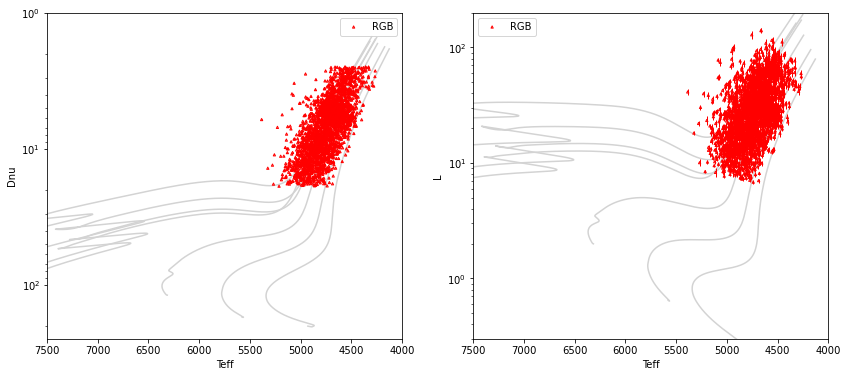

In [174]:
fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=2, squeeze=False)
axes = axes.reshape(-1)

amlt = 1.9 # 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7

idx = (np.isin(newgrid['amlt'], [1.9]))  & (np.isin(newgrid['feh'], [0.])) 
grid = newgrid[idx]

for g in grid:
    filename = gridpath+'pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(g['index'])
    if not os.path.exists(filename): continue
    f = h5py.File(filename, 'r')
    ms = (10.0**(f['log_Lnuc'][:]-f['log_L'][:])>0.99)
    axes[0].plot(f['Teff'][:][ms], f['delta_nu'][:][ms], 
                    linestyle='-', color='lightgray', zorder=-100)
    axes[1].plot(f['Teff'][:][ms], 10.0**f['log_L'][:][ms], 
                    linestyle='-', color='lightgray', zorder=-100)
    f.close()

axes[0].axis([7500,4000,250,1])
axes[0].set_xlabel('Teff')
axes[0].set_ylabel('Dnu')
axes[0].set_yscale('log')

axes[1].axis([7500,4000,0.3, 200])
axes[1].set_xlabel('Teff')
axes[1].set_ylabel('L')
axes[1].set_yscale('log')

msstyle1 = {'c':'k', 'zorder':-100, 'elinewidth':1, 'linestyle':'none'}
msstyle2 = {'marker':'o', 'edgecolor':'k', 'facecolor':'none', 's':50}
sgstyle1 = {'c':'b', 'zorder':-100, 'elinewidth':1, 'linestyle':'none'}
sgstyle2 = {'marker':'s', 'edgecolor':'b', 'facecolor':'none', 's':50}
rgbstyle1 = {'c':'r', 'zorder':-100, 'elinewidth':1, 'linestyle':'none'}
rgbstyle2 = {'marker':'^', 'edgecolor':'r', 'facecolor':'none', 's':5}

# sidx = np.isin(rg['stage'], ['lsg', 'esg']) & (rg['ifmodelling']==1.) & (rg['names'] != 'mu Her')
# midx = np.isin(rg['stage'], ['ms']) & (rg['ifmodelling']==1.) & (rg['names'] != 'Sun')
ridx = rg.index>=0 #np.isin(rg['stage'], ['rgb']) & (rg['ifmodelling']==1.)  & ((rg['e_lum_J']/rg['lum_J']) <0.3)

# axes[0].scatter(rg.loc[sidx,'Teff'], rg.loc[sidx,'Dnu'], label='Subgiants', **sgstyle2)
# axes[1].scatter(rg.loc[sidx,'Teff'], rg.loc[sidx,'lum_J'], label='Subgiants', **sgstyle2)
# axes[0].errorbar(rg.loc[sidx,'Teff'], rg.loc[sidx,'Dnu'], 
#                  yerr=rg.loc[sidx,'e_Dnu'],  **sgstyle1)
# axes[1].errorbar(rg.loc[sidx,'Teff'], rg.loc[sidx,'lum_J'], 
#                  yerr=rg.loc[sidx,'e_lum_J'], **sgstyle1)



# axes[0].scatter(rg.loc[midx,'Teff'], rg.loc[midx,'Dnu'], label='MS', **msstyle2)
# axes[1].scatter(rg.loc[midx,'Teff'], rg.loc[midx,'lum_J'], label='MS', **msstyle2)
# axes[0].errorbar(rg.loc[midx,'Teff'], rg.loc[midx,'Dnu'], 
#                  yerr=rg.loc[midx,'e_Dnu'],  **msstyle1)
# axes[1].errorbar(rg.loc[midx,'Teff'], rg.loc[midx,'lum_J'], 
#                  yerr=rg.loc[midx,'e_lum_J'], **msstyle1)


axes[0].scatter(rg.loc[ridx,'Teff'], rg.loc[ridx,'Dnu'], label='RGB', **rgbstyle2)
axes[1].scatter(rg.loc[ridx,'Teff'], rg.loc[ridx,'luminosity'], label='RGB', **rgbstyle2)
axes[0].errorbar(rg.loc[ridx,'Teff'], rg.loc[ridx,'Dnu'], 
                 yerr=rg.loc[ridx,'e_Dnu'],  **rgbstyle1)
axes[1].errorbar(rg.loc[ridx,'Teff'], rg.loc[ridx,'luminosity'], 
                 yerr=rg.loc[ridx,'e_luminosity'], **rgbstyle1)



# colors = ['orange', 'green']
# names = ['Sun', 'mu Her']
# for i in range(2):
#     idx = rg['names']==names[i]
#     axes[0].scatter(rg.loc[idx,'Teff'], rg.loc[idx,'Dnu'], marker='*', c=colors[i], s=150)
#     axes[1].scatter(rg.loc[idx,'Teff'], rg.loc[idx,'lum_J'], marker='*', c=colors[i], s=150)
    
axes[0].legend()
axes[1].legend()
# fig.colorbar(c, ax=axes).set_label('Mass')

# replace numax values with those from Sree

In [12]:
# stars = pd.read_csv(rootpath+'numax/sample/samples_rg.csv')
# idx = stars.index>=0
# stars['numax_yu'] = stars['numax']
# stars['e_numax_yu'] = stars['e_numax']
# stars = stars.drop(columns=['numax', 'e_numax'])

# t = pd.read_csv(rootpath+'numax/sample/sree_numax.csv')[['KIC', 'numax_iter3', 'nu_error']]
# t['numax'] = t['numax_iter3']
# t['e_numax'] = t['nu_error']
# t = t[['KIC', 'numax', 'e_numax']]

# stars = stars.loc[idx,:].reset_index(drop=True).merge(t, on='KIC')

# ebs = pd.read_csv(rootpath+'numax/sample/samples_eb.csv')

In [14]:
# stars.to_csv(rootpath+'numax/sample/samples_rg.csv', index=False)

In [8]:
m = np.load('../models/uncalibrated/tracks_1000_1999.npy',allow_pickle=True)
df = pd.DataFrame(m)


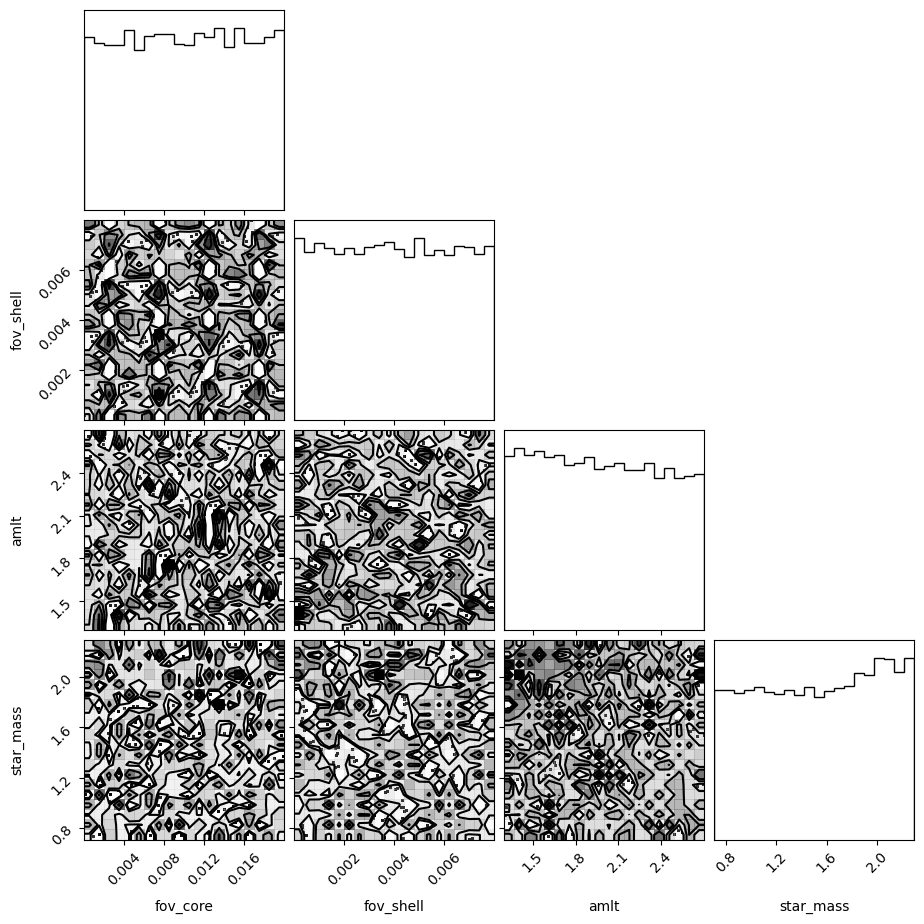

In [13]:
corner.corner(df[['fov_core','fov_shell','amlt','star_mass']]);